# Automated AEKTA kinetics

## Imports

General imports needed for various parts of the phython scripts

In [153]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
import datetime
import matplotlib.pyplot as plt
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
import numpy as np
from matplotlib.ticker import MaxNLocator
from copy import deepcopy
from pycorn import pc_uni6
from pycorn import pc_res3


from scipy.optimize import curve_fit
from scipy.integrate import quad
import pickle
import json


%matplotlib inline


in_dir = os.path.join("testdata")

## Data import

Used to import data from unicorn files.<br>
Call FPLCMethod with a list of prefered channels, if other wavelengths than 260 and 280 nm are used.<br>

In [154]:
class FPLCMethod:
    
    def __init__(self, fplc_file, selected_channels = ["260","280"], uni_version="uni6"):
        
        self.properties = {}
        self.channels = []
        self.file_name = fplc_file
        
        # sets paths for input and output files        
        parent_dir = os.path.relpath(os.path.join(fplc_file,os.pardir))        
        out_dir = os.path.join(parent_dir, 'raw')
        self.out_dir = out_dir
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        out_name = fplc_file.split(os.sep)[-1].split('.')[0]              
        self.out_name = out_name

        # loads data from unicorn files with the help of pycorn.        
        if uni_version == 'uni6':
            self.load_uni6(fplc_file)
        if uni_version == 'uni3':
            self.load_uni3(fplc_file)
        
        # compares the selected channels to the channels found in the unicorn files
        # and ultimately selects the intersecting set
        available_channels = self.channels.keys()
        used_channels = list(set(selected_channels).intersection(available_channels))
        self.channels = dict((key,self.channels[key]) for key in self.channels if key in used_channels)
        
        if len(self.channels) <= 0:
            print("Selected channels are not available!")
            print("selected:", selected_channels)
            print("available:", available_channels)
            self.data_frame = None
        else:
            if len(self.channels) < len(selected_channels):
                print("selected Channels:", selected_channels)
                print("available Channels:", available_channels)
                print("Channels to be used", self.channels.keys())
            self.data_frame = self.get_dataframe(self.data, self.channels, uni_version)
            self.data_frame.to_excel(os.path.join(out_dir, out_name+".xlsx"))
            # pickles properties for later use
            with open(os.path.join(out_dir, out_name+".properties"), "wb") as property_file:
                pickle.dump(self.properties,property_file)
        print("channels:", self.channels)
        
    def load_uni6(self,fplc_file):
        
        """ reads unicorn file and sets channels and properties of the current dataset """
        try:
            self.data = pc_uni6(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)
        self.channels, self.properties["Method Start Time"] = self.get_chromatogram_properties(self.data["Chrom.1.Xml"])
        self.properties.update(self.get_run_properties(self.data["Result.xml"]))
        
    def get_run_properties(self, XML):
        
        """ returns properties of the current dataset """
        
        root = ET.fromstring(XML)
        p = {}
        p["Sample Name"] = root.find("Name").text
        p["Run Name"] = root.find("FolderPath").text.split("/")[-1]
        return(p)
    
    def get_chromatogram_properties(self, XML):
        
        """ returns channels of the current dataset """
        
        channels ={}
        root = ET.fromstring(XML)
        curves = root.find("Curves").findall("Curve")
        curve = [c for c in curves if c.attrib["CurveDataType"] == "UV"]
        for c in curve:
            channel = c.find("Name").text[-3:]
            pts = c.find("CurvePoints")
            pt = pts.find("CurvePoint")
            channel_file = pt.find("BinaryCurvePointsFileName")
            channels[channel] = channel_file.text
        if len(channels) > 0:
            method_start = datetime.datetime.strptime(curves[0].find("MethodStartTime").text,"%Y-%m-%dT%H:%M:%S.%f")
        return(channels, method_start)
                    
    def load_uni3(self,fplc_file):
        
        """ reads unicorn file and sets channels and properties of the current dataset """
        
        try:
            self.data = pc_res3(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)

        channels = {}
        for key in self.data.keys():
            if "UV" in key:
                channels[key[4:7]] = key
        self.channels = channels  
        self.properties["Sample Name"] = self.data['Logbook']['run_name']
        self.properties["Run Name"] = fplc_file.split(os.sep)[0]
        self.properties["Method Start Time"] = datetime.datetime.strptime(self.data['Logbook']['data'][0][1][11:31], "%d.%m.%Y, %H:%M:%S")        

    def get_primary_channel(self, df):
        
        """ returns the primary channel. Te primary channel is based on the Unicorn method settings.
            The first wavelength typed usually has a shorter sampling timer than the rest """
        
        channel_data_length = dict((c,len(df[c])) for c in df)
        return(max(channel_data_length, key=channel_data_length.get))

    def get_dataframe(self, data, channels, uni_version):
        
        """ returns a processed data frame. The first column is a list of timepoints. 
            The subsequent columns are absorbance values for each available channel """
    
        df = {}
    
        for c in channels:
            values = {}
            if uni_version == 'uni6':
                x = data[channels[c]]["CoordinateData.Volumes"]
                y = data[channels[c]]["CoordinateData.Amplitudes"]
            elif uni_version == 'uni3':              
                x,y = zip(*data[channels[c]]['data'])
            else:
                x,y = None
            values["Volume"] = x
            values[c] = y
            values_df = pd.DataFrame(values)
            # remove key values (=Volume) that are duplicate.
            df[c] = values_df.groupby((values_df["Volume"] != values_df["Volume"].shift()).cumsum().values).first()
    
        primary_channel = self.get_primary_channel(df)
        merged_df = df[primary_channel]
        for c in df:
            if c != primary_channel:
                merged_df = merged_df.merge(df[c], on="Volume", how="left")
        merged_df = merged_df.reindex_axis(sorted(merged_df.columns, reverse=True), axis=1)
        return(merged_df)
    
    def plot(self, savefig=False):
        
        """ plots the current chromatogram """
        
        plt.clf()
        if self.data_frame is not None:
            print(self.properties)
            df = self.data_frame.dropna()
            print(df.columns[2:])
            for channel in df.columns[1:]:
                plt.plot(df["Volume"], df[channel],label=channel)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))                            
            if savefig:                                
                plt.savefig(os.path.join(self.out_dir, self.out_name+"_chromatogram.eps"), bbox_inches="tight")                
            plt.show()
            
def list_files(path, filetypes):
    
    """ reutrns a list of all files with the selected filetype in the specified folder """
    
    data_files =[]
    for f in sorted(os.listdir(path)):
        if f.endswith(tuple(filetypes)):
            data_files.append(os.path.join(path,f))
    return(data_files)
        
def import_FPLCRuns(in_dir, selected_channels=["260","280"]):
    
    """ imports all data files in a specified folder and returns a list of FPLCMethods """
                
    file_names = list_files(in_dir, ["zip", "res"])
    FPLC_runs = []
        
    for f in file_names:
        print(f)
        if f[-4:].lower() == ".res":
            uni_v = "uni3"
        elif f[-4:].lower() == ".zip":
            uni_v = "uni6"
        else:
            print("Can not process unsuported Filetype:", f[-4:].lower())
            return(None)
        m = FPLCMethod(f, selected_channels, uni_version=uni_v)
        FPLC_runs.append(m)
    return(FPLC_runs)


In [155]:
chromatograms = import_FPLCRuns(in_dir, selected_channels=["260"])

testdata\08112018001.res
channels: {'260': 'UV1_260nm'}
testdata\08112018002.res
channels: {'260': 'UV1_260nm'}
testdata\08112018003.res
channels: {'260': 'UV1_260nm'}
testdata\08112018004.res
channels: {'260': 'UV1_260nm'}
testdata\08112018005.res
channels: {'260': 'UV1_260nm'}
testdata\08112018006.res
channels: {'260': 'UV1_260nm'}
testdata\08112018007.res
channels: {'260': 'UV1_260nm'}
testdata\08112018008.res
channels: {'260': 'UV1_260nm'}


# Correct chromatograms

Subtracts the baseline from chromatograms.

In [156]:
class Chromatogram_cor:
    def __init__(self, data_frame, cut_off = None, baseline_df=None):
        
        """ A corrected chromatogram. 
            Correction is done by subtracting a baseline and applying a cut_off """
        
        df = data_frame.dropna()        
        self.df = df        
        self.x = df[df.columns[0]]
        self.y = df[df.columns[1]]
        self.baseline_df = baseline_df
        if baseline_df is not None:
            self.baseline, self.corrected_y = self.make_baseline()        
        self.id = df.columns[1]        
        self.start = cut_off
                
        if cut_off is not None:            
            self.start_ind = min([i for i in range(0,len(self.x)) if self.x.iloc[i] >= self.start])                    
            self.x = self.x[self.start_ind:]
            self.y = self.y[self.start_ind:]
            self.x = self.x.reset_index(drop=True)
            self.y = self.y.reset_index(drop=True)
        else:
            self_start_ind = 0
                    
        if baseline_df is not None:
            if cut_off is not None:
                self.baseline = self.baseline[self.start_ind:]
                self.baseline = self.baseline.reset_index(drop=True)
                self.corrected_y = self.corrected_y[self.start_ind:]
                self.corrected_y = self.corrected_y.reset_index(drop=True)    
            self.orig_y = self.y
            self.y = self.corrected_y
        else:
            self.corrected_y = None
            self.baseline = None
            self.orig_y = None
        
    def make_baseline(self):  
        merged_df = pd.merge(self.df, self.baseline_df, how='left', on=self.df.columns[0]).fillna(0)           
        bl = merged_df[merged_df.columns[2]]        
        cor_y = merged_df[merged_df.columns[1]] + (bl *-1)        
        return(bl, cor_y)
    
    def plot_correction(self, savefig=False):
        plt.clf()
        if self.df is not None:            
            df = self.df.dropna()
            for channel in df.columns[1:]:
                plt.plot(self.x, self.orig_y,label=channel)
                plt.plot(self.x, self.corrected_y,label=channel+'_corrected')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))                            
            if savefig:                                
                plt.savefig(os.path.splitext(self.file_name)[0]+"_chromatogram_corrected.eps", bbox_inches="tight")
            plt.show()

    
def list_files(path, filetypes):
    data_files =[]
    for f in sorted(os.listdir(path)):
        if f.endswith(tuple(filetypes)):
            data_files.append(os.path.join(path,f))
    return(data_files)
        
def correct_Chromatograms(in_dir, cut_off=1.50, baseline=True, savefig=False):
    
    """ returns a list of baseline-corrected chromatograms and applies a cut_off """

    parent_dir = in_dir
    baseline_file = os.path.join(in_dir,'baseline.xlsx')
    out_dir = os.path.join(in_dir, 'corrected')
    
    in_dir = os.path.join(in_dir, 'raw')    
    file_names = list_files(in_dir, [".xlsx"])
    
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    Chromatograms = []     
    if baseline and not os.path.exists(baseline_file):
        print('!!! no baseline file found to make the baseline correction !!!')
        bl_df = None
    else:
        if baseline:
            bl_df = pd.read_excel(baseline_file, index_col=[0])
        else:
            bl_df = None   
        for f in file_names:
            out_name = f.split(os.sep)[-1].split('.')[0]
            print('out_name', out_name)
            df = pd.read_excel(f, index_col=[0])
            m = {}             
            corrected_df = pd.DataFrame()
      
            plt.clf()
            
            for channel in df.columns[1:]:
                print("channel", f, channel)
                m[channel] = Chromatogram_cor(df[[df.columns[0], channel]], cut_off = cut_off, baseline_df = bl_df[[bl_df.columns[0], channel]])                                                
     
                if corrected_df.empty:
                    print("corrected_df is empty")
                    corrected_df = pd.DataFrame({df.columns[0]:m[channel].x})                
                corrected_df[channel] = m[channel].y                
                plt.plot(corrected_df[corrected_df.columns[0]], corrected_df[channel], label=channel+'corrected')

            corrected_df.to_excel(os.path.join(out_dir,out_name+'.xlsx'))                                    
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))                                        
            if savefig:                          
                plt.savefig(os.path.join(out_dir,out_name+"_corrected.eps"), bbox_inches="tight")                
            plt.show()
            
            Chromatograms.append(m)
    return(Chromatograms)       



out_name 08112018001
channel testdata\raw\08112018001.xlsx 260
corrected_df is empty


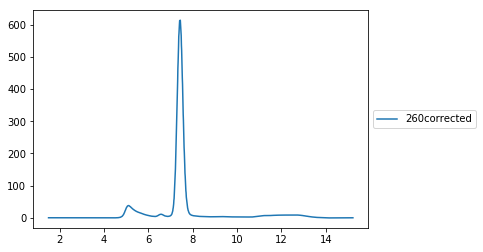

out_name 08112018002
channel testdata\raw\08112018002.xlsx 260
corrected_df is empty


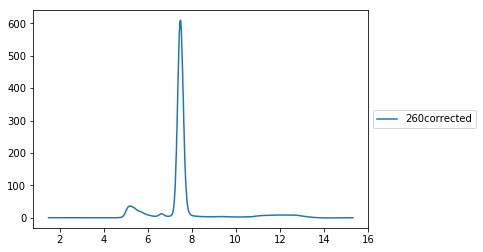

out_name 08112018003
channel testdata\raw\08112018003.xlsx 260
corrected_df is empty


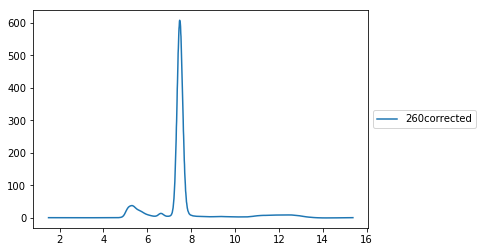

out_name 08112018004
channel testdata\raw\08112018004.xlsx 260
corrected_df is empty


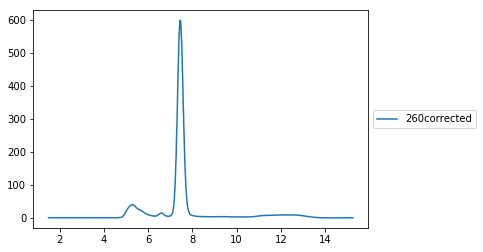

out_name 08112018005
channel testdata\raw\08112018005.xlsx 260
corrected_df is empty


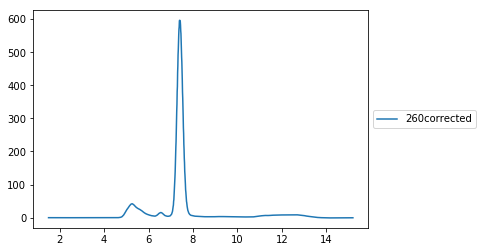

out_name 08112018006
channel testdata\raw\08112018006.xlsx 260
corrected_df is empty


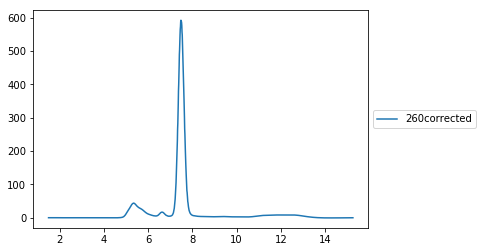

out_name 08112018007
channel testdata\raw\08112018007.xlsx 260
corrected_df is empty


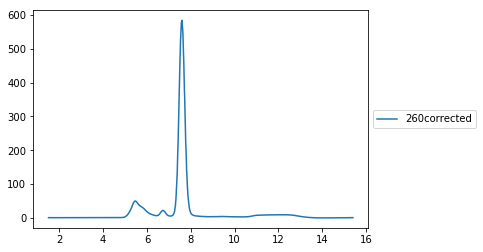

out_name 08112018008
channel testdata\raw\08112018008.xlsx 260
corrected_df is empty


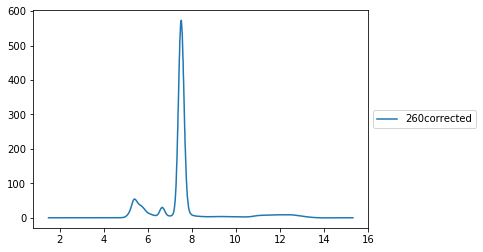

In [157]:
chromatograms = correct_Chromatograms(in_dir, baseline=True, savefig=True)

## Peak detection

Tries to find peaks and set their properties (start, end, centre, height, width)<br>
Peak detection based on a MATLAB script by Eli Billauer<br><br>

ALL chromatograms of a certain channel are combined in one table of peaks here!<br>
Peaks of successive chromatograms are bined together based on their properties<br><br>

<font color="red">It is crucuial to check the excel files after the following step before continuing to the next!</font><br>
If peaks, that should be in the same bin, are separated, they need to be put in the same bin.<br>
This can be done manually in the excel sheet or by improving the parameters for peak detection and/or binning.


In [158]:
class Chromatogram:
    def __init__(self, data_frame):        
        df = data_frame.dropna()
        self.df = df
        self.x = df[df.columns[0]]
        self.y = df[df.columns[1]]
        self.id = df.columns[1]
        self.peak_minima = []
        self.peak_maxima = []
                
    def get_hsm(self, high):
        
        """ returns the highest minima that is still smaller than the high parameter """
        
        minimas = [m[0] for m in self.peak_minima if self.x.iloc[int(m[0])] < high]
        if len(minimas) >= 1:
            hsm = max(minimas)
        else:
            hsm = 0
        return(int(hsm))            
        
    def get_lbm(self, low):
        
        """ returns the lowest minima that is still bigger than the low parameter """
        
        minimas = [m[0] for m in self.peak_minima if self.x.iloc[int(m[0])] > low]
        if len(minimas) >= 1:
            lbm = min(minimas)
        else:
            lbm = len(self.x)-1
        return(int(lbm))    
        
    def get_peaks(self, delta=0.005):                         
        self.peak_centre, self.peak_minima = self.peakdet(self.y, delta)
        return(self.peak_centre, self.peak_minima)
    
    def peakdet(self, v, delta, x = None):
        """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
        Returns two arrays
    
        function [maxtab, mintab]=peakdet(v, delta, x)
        %PEAKDET Detect peaks in a vector
        %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        %        maxima and minima ("peaks") in the vector V.
        %        MAXTAB and MINTAB consists of two columns. Column 1
        %        contains indices in V, and column 2 the found values.
        %      
        %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        %        in MAXTAB and MINTAB are replaced with the corresponding
        %        X-values.
        %
        %        A point is considered a maximum peak if it has the maximal
        %        value, and was preceded (to the left) by a value lower by
        %        DELTA.
        
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    
        """
        maxtab = []
        mintab = []
       
        if x is None:
            x = arange(len(v))
    
        v = asarray(v)
    
        if len(v) != len(x):
            sys.exit('Input vectors v and x must have same length')
    
        if not isscalar(delta):
            sys.exit('Input argument delta must be a scalar')
    
        if delta <= 0:
            sys.exit('Input argument delta must be positive')
    
        mn, mx = Inf, -Inf
        mnpos, mxpos = NaN, NaN
    
        lookformax = True
    
        for i in arange(len(v)):
            this = v[i]
            if this > mx:
                mx = this
                mxpos = x[i]
            if this < mn:
                mn = this
                mnpos = x[i]
        
            if lookformax:
                if this < mx-delta:
                    maxtab.append((mxpos, mx))
                    mn = this
                    mnpos = x[i]
                    lookformax = False
            else:
                if this > mn+delta:
                    mintab.append((mnpos, mn))
                    mx = this
                    mxpos = x[i]
                    lookformax = True

        return array(maxtab), array(mintab)
    
    
    def get_guess(self):
        """returns a list of guesses for the peak parameters
            [0]=peak_center, [1]=peak_amp, [2]=peak_width"""
        minima = []
        peaks = []
        
        for n in self.peak_minima:
            minimum = self.x.iloc[int(n[0])]
            minima.append(minimum)

        for n in self.peak_centre:
            peak_amp = self.y.iloc[int(n[0])]
            peak_centre = self.x.iloc[int(n[0])]
            peaks.append([peak_centre, peak_amp, 0])
    
        if len(peaks) <= len(minima)+1:
            for i in range(0,len(peaks)):
                if i < len(minima):
                    peaks[i][2] = ((minima[i]-peaks[i][0])/4)
                elif len(minima) <= 0:
                    peaks[i][2] = 0.05
                else:
                    peaks[i][2] = ((peaks[i][0]-minima[i-1])/4)
        else:
            print("Can't find peak width!")

        guess = [item for sublist in peaks for item in sublist]
        return(guess)
    
def list_files(path, filetypes):
    data_files =[]
    for f in sorted(os.listdir(path)):
        if f.endswith(tuple(filetypes)):
            data_files.append(os.path.join(path,f))
    return(data_files)


def nice_format(f):
    return ("{:.2f}".format(f))
    
def analyse_Peaks(in_dir, peak_delta=0.005, savefig=False):
    
    """ analyses chromatograms (corrected or original) and exports a table with peaks for each selected 
        wavelength.
        peak_delta has to be adjusted based on the minimum height of peaks in a chromatogram
        smaller delta --> detection of smaller bumps as peaks. 
        to small delta --> detection of noise as peaks """
           
    peaks_df = pd.DataFrame()
    
    parrent_dir = in_dir    
    peak_dir = os.path.join(in_dir, 'peaks')    
    in_dir = os.path.join(in_dir, 'corrected')    
        
    file_names = list_files(in_dir, [".xlsx"])
    
    if not os.path.exists(peak_dir):
        os.makedirs(peak_dir)

    Chromatograms = []
    channel_dfs = {}
     
    for f in file_names:
        out_name = f.split(os.sep)[-1].split('.')[0]
        
        # imports properties for current chromatogram that have been pickled before (Data import)
        with open(os.path.join(parrent_dir,'raw',out_name + ".properties"), 'rb') as properties_file:
            properties = pickle.loads(properties_file.read())
                
        df = pd.read_excel(f, index_col=[0])
        m = {}        

        
        # building up a table of peaks for each channel
        
        for channel in df.columns[1:]:                    
            peak_df = pd.DataFrame()

            out_dir = os.path.join(peak_dir, channel)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            
            plt.clf()
            m[channel] = Chromatogram(df[[df.columns[0], channel]])
            print(f, channel)
            minima, maxima = m[channel].get_peaks(delta = peak_delta)
            guess = m[channel].get_guess()         
            for i in range(0, len(guess), 3):
                tmp_df = pd.DataFrame()
                peak_start_ind = m[channel].get_hsm(guess[i])
                peak_end_ind = m[channel].get_lbm(guess[i])
                peak_ind = max([x for x in range(0,len(m[channel].x)) if m[channel].x.iloc[x] <= guess[i]])     
                
                plt.plot(df[df.columns[0]][peak_start_ind:peak_end_ind], df[channel][peak_start_ind:peak_end_ind], label=m[channel].x[peak_ind])
                plt.plot(df[df.columns[0]][peak_ind], df[channel][peak_ind]+1 , '+', color='black')                                
                                                
                h_peak_id = nice_format(m[channel].x[peak_ind])
                h_order = ['start','end','centre','amplitude', 'width', 'integration_method']
                h_names = ['id','prop']
                
                
                #very rudimentary bining of peaks --> needs improvement
                if channel in channel_dfs.keys():
                    pid = None
#                    low = guess[i] - guess[i+2]
#                    high = guess[i] + guess[i+2]
                    low = m[channel].x[peak_start_ind]
                    high = m[channel].x[peak_end_ind]
                    for peak_id in channel_dfs[channel].columns.levels[0]:    
                        if float(low) < float(peak_id) < float(high):
                            pid = peak_id
                            #break
                    if pid is None:
                        print('couldnt find pid', pid)
                        pid = guess[i]
                    else:
                        h_peak_id = pid        
                
                peak_header = pd.MultiIndex.from_product([[h_peak_id],
                                     h_order])

                

                # integration_methode can be altered manualy for each peak in the excel_file
                # [n]umerical works better, if peaks are not perfect [g]aussians
                
#               integration_methode = 'g'
                integration_methode = 'n'
                    
                tmp_df = pd.DataFrame([[nice_format(m[channel].x[peak_start_ind]),
                                        nice_format(m[channel].x[peak_end_ind]),
                                        nice_format(guess[i]),
                                        nice_format(guess[i+1]),
                                        nice_format(guess[i+2]),
                                        integration_methode
                                       ]],
                                       columns=peak_header,
                                        index = [[properties['Sample Name']], [properties['Method Start Time']]])
                                    
                peak_df = pd.concat([peak_df, tmp_df], axis=1)
                    
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))                                        
            if savefig:                          
                plt.savefig(os.path.join(out_dir,out_name+"_peaks.eps"), bbox_inches="tight")
            plt.show()           

            if channel in channel_dfs.keys():                
                root_df = channel_dfs[channel]             
                root_df = root_df.append(peak_df)                                
            else: 
                root_df = peak_df.copy(deep=True)                
            channel_dfs[channel] = root_df
            
        Chromatograms.append(m)
        
    for channel in channel_dfs.keys():
        print(os.path.join(peak_dir,channel,"peaks.xlsx"))        
        channel_dfs[channel].to_excel(os.path.join(peak_dir,channel,"peaks.xlsx"))        
    return(Chromatograms, channel_dfs)



testdata\corrected\08112018001.xlsx 260


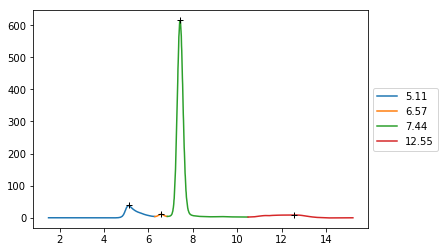

testdata\corrected\08112018002.xlsx 260


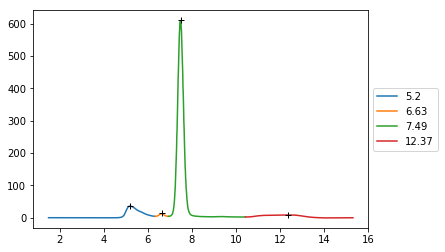

testdata\corrected\08112018003.xlsx 260


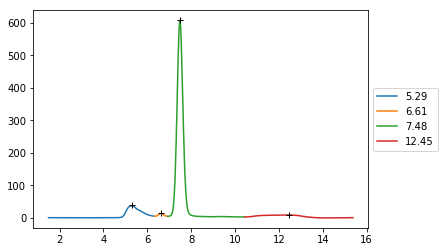

testdata\corrected\08112018004.xlsx 260


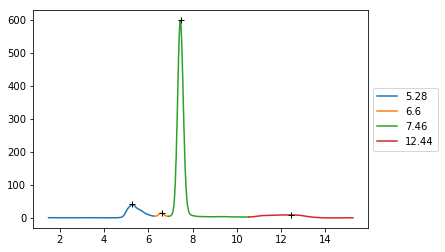

testdata\corrected\08112018005.xlsx 260


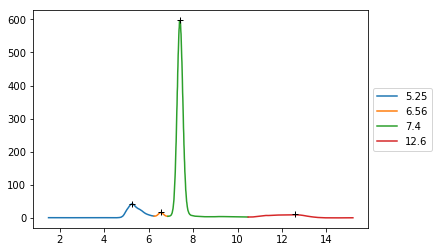

testdata\corrected\08112018006.xlsx 260


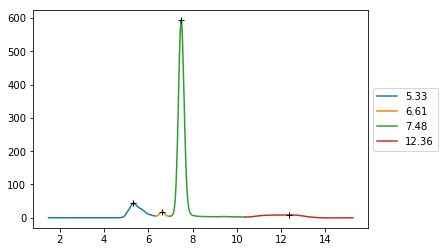

testdata\corrected\08112018007.xlsx 260


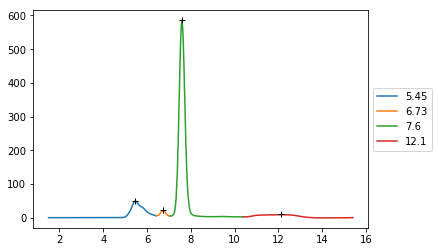

testdata\corrected\08112018008.xlsx 260


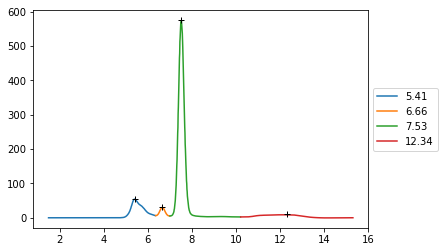

testdata\peaks\260\peaks.xlsx


In [159]:
chromatograms, channel_df = analyse_Peaks(in_dir, peak_delta=1, savefig=True)

## Identify peaks

Peaks are identified and bin headers are named based on the elution volume borders specified in the peaks.id file.<br>
File has JSON syntax:<br>
<br>
{"Protein_X": [0, 6], "ATP": [6, 9]}

In [160]:
def get_id(pid, ids):
    prot_id = [i for i in ids if float(ids[i][0]) <= float(pid) <= float(ids[i][1])]
    if len(prot_id) < 1:
        prot_id = pid
    else:
        prot_id = prot_id[0]
    return(prot_id)  

def get_channels(in_dir):
    subdirs = next(os.walk(in_dir))[1]
    return(subdirs)

def identify_Peaks(in_dir):
    
    parent_dir = in_dir
    id_file = os.path.join(parent_dir, 'peaks.id')

    with open(id_file, 'r') as id_handle:
        identities = json.load(id_handle)
        print(identities)
    
    in_dir = os.path.join(in_dir, 'peaks')    
    peak_dict = {}
    for subdir in get_channels(in_dir):
        peaks_file = os.path.join(in_dir, subdir ,'peaks.xlsx')        
        peaks_df = pd.read_excel(peaks_file, header=[0,1], index_col=[0,1])

        for i in range(0,len(peaks_df.columns._levels[0].values)):
            peaks_df.columns._levels[0].values[i] = get_id(peaks_df.columns._levels[0].values[i],identities)
            
        out_name = peaks_file.split('.')[0] + '_id.xlsx'        
        peaks_df.to_excel(out_name)
        peak_dict[subdir] = peaks_df
    return(peak_dict)  

In [161]:
result = identify_Peaks(in_dir)

{'target': [0, 6], 'ADP': [6, 7], 'ATP': [7, 8]}


## Peak fitting

Peak fitting based on the information in the peaks.xlsx files. Yields relative peak areas.
<font color="red">Make sure the files look good (proper peaks binned together, etc.) before continuing with the following step!</font><br>
Note: This part can't handle peaks that appear or disapear (peak columns with 1 or more empty fields in peaks.xlsx).<br>
If there is a peak appearing from nothing or disapearing completely over time, add the parameters for it's position (as in other fields) with amplitude 0 as a quick fix.

In [162]:
class Peak:
    def __init__(self, x=[], y=[], start=0, end=0, ctr=0, amp=0, wid=0, method='g'):
        self.start = start
        self.end = end
        self.centre = ctr
        self.amplitude = amp
        self.fwhm = wid
        self.x = x
        self.y = y
        self.method = method
        self.fit = None
        self.area = None


        if (self.x<=self.start).any():
            peak_start_ind = self.x[self.x<=self.start].index.values.astype(int)[-1]
            self.start_ind = peak_start_ind
        else:
            print("coudnt find index of ", self.start)
        
        
        if (self.x>=self.end).any():
            peak_end_ind = self.x[self.x>=self.end].index.values.astype(int)[0]
            self.end_ind = peak_end_ind
        else:
            print("coudnt find index of ", self.end)         
        
        # filling up the peak data with 0 values before its start and after its end for plotting
        
        pre_peak = np.zeros_like(self.y[0:peak_start_ind])
        peak = self.y[peak_start_ind:peak_end_ind]
        post_peak = np.zeros_like(self.y[peak_end_ind:len(self.y)])

        self.y = list(pre_peak) + list(peak) + list(post_peak)                
        
        
    def gaussian_func_draw(self, x):
        
        """ get y of a simulated gaussian based on the current peak data"""
        
        y = 0
        ctr = self.centre
        amp = self.amplitude
        wid = self.fwhm
        y = y + amp * np.exp( -(x - ctr)**2 / (2*wid**2))
        return y

    
    def gaussian_func(self, x, *params):
        
        """ gaussian fit function """
        
        y = np.zeros_like(x)
        if len(params) == 1:
            params = params[0]
        for i in range(0, len(params), 3):
            try:
                ctr = params[i]
                amp = params[i+1]
                wid = params[i+2]
                y = y + amp * np.exp( -(x - ctr)**2 / (2*wid**2))
            except:
                print("Error with params",params)
                print("len",len(params))
                print("len[0]", len(params[0]))
                
        return y      
    
    def fit_peak(self,method=None):
        if method is not None:
            self.method = method
            
        #if there are less datapoints then parameters, a fit can not be done
        #however, this also means a very narrow peak and thus the area corresponds to the height
        
        if len(self.x) <= 3:
            print('Not enough datapoints to fit peak', self.centre)
            self.area = self.y
        else:
            if self.method == 'g':
                self.area = self.gausian_fit()
            elif self.method == 'n':
                self.fit = self.y
                self.area = np.trapz(self.y, self.x)

    def get_gaussian_area(self):
        return(quad(self.gaussian_func_draw,self.x.iloc[0], self.x.iloc[-1])[0])

    def gausian_fit(self):
        
        """ fit a gaussian to the peak datapoints """
        
        try:
            popt, pcov = curve_fit(self.gaussian_func, self.x, self.y, p0=[self.centre, self.amplitude, self.fwhm])
            p_error = np.sqrt(np.diag(pcov))/popt*100            
            key = popt[0]
            if any(p_error >= 20):
                print("!"*20)
                print("Peak optimization failed.")
                print("guess", guess[i:i+3])
                print("optimization", popt)
                print("optimization error (percent)", p_error)
                print("x:", self.x.iloc[self.peak_start_ind], self.x.iloc[self.peak_end_ind])
                print("y:", self.y.iloc[self.peak_start_ind], self.y.iloc[self.peak_end_ind])
                print("!"*20)
            else:
                self.fit = self.gaussian_func(self.x, *popt)
        except RuntimeError as e:
            print(" - ".join(["Could not fit peak",self.centre,",".join([self.centre, self.amplitude, self.fwhm])]))                               
        return(self.get_gaussian_area())

    
def get_channels(in_dir):
    subdirs = next(os.walk(in_dir))[1]
    return(subdirs)
    
def peak_fitting(in_dir, delay=120, savefig=False):
    
    setup_delay = delay

    chrom_dir = os.path.join(in_dir, 'corrected')

    fit_dir = os.path.join(in_dir, 'peak_fits')
    if not os.path.exists(fit_dir):
        os.makedirs(fit_dir)
    
    in_dir = os.path.join(in_dir, 'peaks')
    fitting_dict = {}
    for channel in get_channels(in_dir):        
        fit_channel_dir = os.path.join(fit_dir, channel)
        if not os.path.exists(fit_channel_dir):
            os.makedirs(fit_channel_dir)
        in_file = os.path.join(in_dir, channel,'peaks_id.xlsx')
    
        try:
            peaks_df = pd.read_excel(in_file, header=[0,1], index_col=[0,1])
        except ValueError as ve:
            print(ve)
            print("Check peaks_id.xlsx. Multible bins have probably been labeled with the same identifier from peaks.id .")
            raise
    
        previous_time = None
        delta_t = setup_delay
    
        prog_df = pd.DataFrame()
    
        for chrom_ind, chrom_time in peaks_df.index.values:                        
            chrom_str = str(chrom_ind)
            if len(chrom_str) < 11:
                chrom_str = '0'+chrom_str
                
            chrom_file = os.path.join(chrom_dir, chrom_str+'.xlsx')                    
            chrom_df = pd.read_excel(chrom_file, index_col=[0])       
            
            chrom_peaks = {}
            plt.clf()        
            for peak_id in sorted(peaks_df.columns.levels[0]):            
                if peak_id != 'id':
                    peak_dict = {}
                    for peak_prop in peaks_df.columns.levels[1]: 
                        peak_dict[peak_prop] = peaks_df.loc[(chrom_ind,chrom_time),pd.IndexSlice[peak_id, peak_prop]]
                        ### !!!! quick workaround!!!! best would be to have the index not convert this
                        ### into an int and delete the trailing 0

                    pk = Peak(x=chrom_df[chrom_df.columns[0]], y=chrom_df[channel],
                              start = peak_dict['start'],
                              end = peak_dict['end'],
                              ctr = peak_dict['centre'],
                              amp = peak_dict['amplitude'],
                              wid = peak_dict['width'],
                              method = peak_dict['integration_method']                          
                             )
                    pk.fit_peak()
                    chrom_peaks[peak_id] = pk
               
                    plt.plot(pk.x,pk.fit,label=peak_id)
            plt.plot(chrom_df[chrom_df.columns[0]], chrom_df[channel], linestyle=':', color='black',label=chrom_str)

            if previous_time is None:
                previous_time = chrom_time

            delta_t = delta_t + int((chrom_time - previous_time).total_seconds())
            previous_time = chrom_time

            if prog_df.empty:
                prog_headers = list(chrom_peaks.keys())
            peak_area_list = [chrom_peaks[pid].area for pid in chrom_peaks.keys()]
            prog_df = prog_df.append(pd.DataFrame([peak_area_list],columns=prog_headers, index=[delta_t]))                      

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
#            plt.axis([None,None,-5,650])
            plt.axis([None,None,-5,None])

            if savefig:                          
                plt.savefig(os.path.join(fit_channel_dir,chrom_str + "_peaks.eps"), bbox_inches="tight")
            plt.show()                   

        prog_df.to_excel(os.path.join(fit_channel_dir,"peak_areas.xlsx"))
        fitting_dict[channel] = prog_df
    return(fitting_dict)

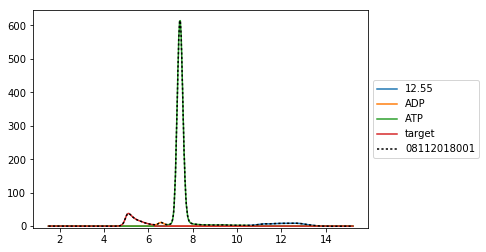

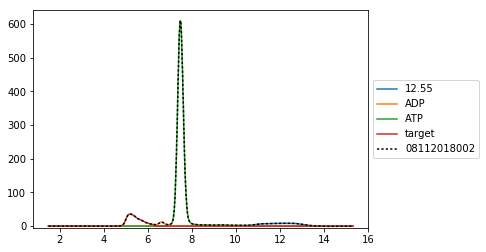

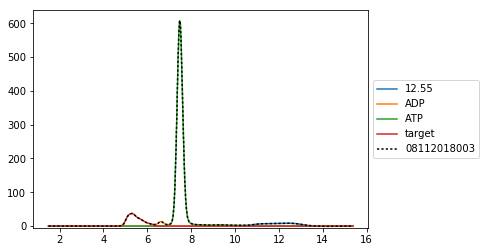

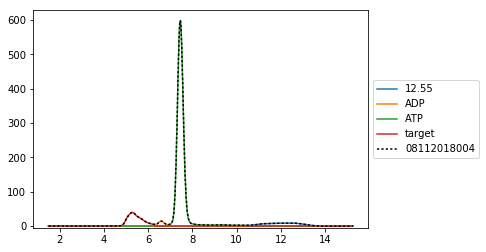

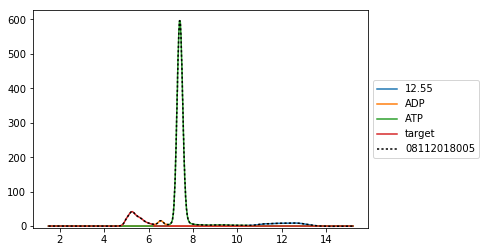

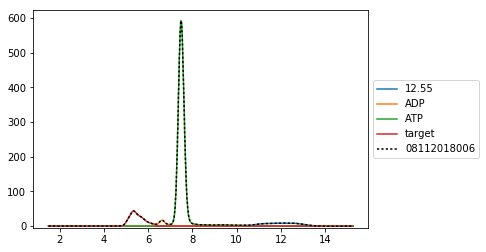

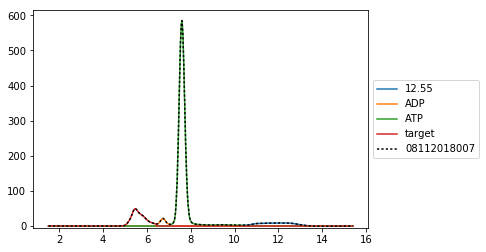

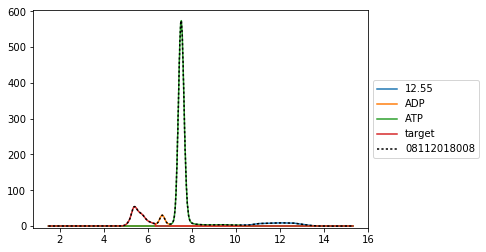

In [163]:
progs_df = peak_fitting(in_dir, delay=120, savefig=True)

## Progression fitting

Fitting of the progression of binned and fitted peaks. <br>
Plots the progression and writes a table with velocities, errors and values at x = 0 (= time extrapolated to 0) for each channel.<br>

In [164]:
def poly2_equ(x, c,b,a):
    return(c + b*x + a*x**2)

def fit_poly2(xdata,ydata,coefs):
    popt, pcov = curve_fit(poly2_equ, xdata, ydata, coefs)
    return(popt, pcov)

def abline(slope, intercept,x,label, cc, ax):
    """Plot a line with slope and intercept"""
    
    x = range(0,1250)
    y = intercept + slope * x
    ax.plot(x, y, '--',color=cc,label=label)
    
def errorcone(slope, intercept,x,error,label, cc, ax):
    """Plot a line from slope and intercept"""
    x = range(0,1250)
    yhigh = intercept + (slope + error) * x
    ylow = intercept + (slope - error) * x
    ax.fill_between(x, ylow, yhigh, color=cc, alpha = 0.3)

def poly_fit(x,y,cc, ax, vel_df = pd.DataFrame, cone=True):
    
    """ fits a polynom to the data and returns the parameters """
    
    # initial first guess of the polynom
    coefs = [1,1,1]
    
    popt,pcov = fit_poly2(x.values,y.values,coefs)             
    p_errors = np.sqrt(np.diag(pcov))    

    # plot the fit function with the fited parameters
    ax.plot(x, poly.polyval(x, popt), linestyle=':',marker="",color='black')            
    # extrapolate back to x = 0
    ax.plot(0, poly.polyval(0, popt),'x',color=cc)
    
    #first derivative of the function    
    fder_coefs = poly.polyder(popt)    
    #slope at x = 0
    slope = poly.polyval(0,fder_coefs)
    #plot slope 
    abline(slope,poly.polyval(0, popt),x,'v0', cc, ax)
        
        
    # plot cone if cone = True and error of the slope is not infinite
    if not np.isinf(p_errors[1]):
        if cone:
            errorcone(slope,poly.polyval(0, popt),x,p_errors[1],'v0+stdev', cc, ax)
  
    header = ['velocity','y0','error']

    if vel_df.empty:  
        vel_df = pd.DataFrame([[slope,poly.polyval(0, popt),p_errors[1]]], columns=header, index=[y.name])        
    else:
        c_df = pd.DataFrame([[slope,poly.polyval(0, popt),p_errors[1]]], columns=header, index=[y.name])
        vel_df = pd.concat((vel_df, c_df), axis=0, join='outer')    
    return(slope, popt, p_errors[1], vel_df)

def get_channels(in_dir):
    subdirs = next(os.walk(in_dir))[1]
    return(subdirs)

def progression(in_dir, savefig=False, hide_unknown=False, cone=True):
    parent_dir = in_dir    
    in_dir = os.path.join(in_dir, 'peak_fits')
    channel_dict = {}   
    
    for channel in get_channels(in_dir):
        plt.clf()
        fig = plt.figure(1)
        ax = fig.gca()
        figsize = 8 #cm
        fig.set_size_inches(figsize/2.54, figsize/2.54)        
        
        channel_dir = os.path.join(in_dir, channel)
        area_file = os.path.join(channel_dir,'peak_areas.xlsx')        
                
        peaks_df = pd.read_excel(area_file, index_col=[0])        
        print (peaks_df)
        # drop values after 2200 seconds
        # drops = [r for r in peaks_df.index if r > 2200]
        drops = []
        if len(drops) > 0:
            peaks_df = peaks_df.drop(drops)
                                        
        # repress ploting of unknown peaks (= no identification based on peaks.id) if hide_unknwon = True
        if hide_unknown:
            id_file = os.path.join(parent_dir, 'peaks.id')
            with open(id_file) as id_handle:
                identities = json.load(id_handle)
            known_ids = list(set(identities.keys()).intersection(set(peaks_df.columns)))
            peaks_df = peaks_df[known_ids]
            
        v_df = pd.DataFrame() 
        vel_df = pd.DataFrame()
        for pid in peaks_df.keys():            
            tmp_df = peaks_df[pid]
            tmp_df = tmp_df.dropna()
                
            tmp_df = tmp_df.iloc[0:len(tmp_df)]                
                                
            # only plot target values
            if pid == 'target':
                p = plt.plot(tmp_df.index, tmp_df, linestyle='',marker='o', markersize=5, label=pid)                
                current_color = p[-1].get_color() 
                slope, coefs, p_err, vel_df = poly_fit(tmp_df.index, tmp_df, current_color,ax,vel_df,cone)
                v_df = pd.concat([v_df, pd.DataFrame([slope],columns=[pid])],axis=1, join='inner')              

        vel_df.to_excel(os.path.join(parent_dir, 'velocity_rel_' + channel + '.xlsx'))       
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
        ax.title.set_text(" ".join(str.split(str.split(parent_dir,"/")[-1]," ")[1:]))
    
        font = {'size': 10}    
        plt.axis([-120,int(peaks_df.index[-1])*1.05,0,None])    
        if savefig:                          
            plt.savefig(os.path.join(parent_dir, 'progression_rel_'+channel+'.png'), dpi=400, bbox_inches="tight")
        plt.show()                  
        channel_dict[channel] = peaks_df
    return(channel_dict)



          12.55        ADP         ATP     target
120   18.822154   4.026570  208.108210  25.214221
480   18.086930   4.542538  205.097044  26.773119
840   18.197556   4.934444  204.273166  28.362066
1201  18.462186   5.369984  202.160424  29.779826
1562  18.257192   5.639630  200.710002  30.253668
1922  18.315726   6.093770  198.897228  30.797286
2283  18.304452   7.544842  196.508960  33.276893
3545  19.579734  10.190966  191.950242  35.008714


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


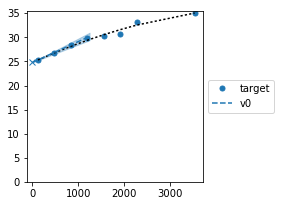

In [165]:
peaks_df = progression(in_dir, savefig=True, hide_unknown=True, cone=True)

## Make baseline file (optional)

A quickly striped down Unicorn importer that creates a baseline file from blank method runs.<br>
Reads all Unicorn files from a folder and exports a table with average absorbance values for each channel.

In [166]:
class FPLCBaseline:

    def __init__(self, fplc_file, selected_channels = ["260","280"], uni_version="uni6"):
        
        self.properties = {}
        self.channels = []
        self.file_name = fplc_file
        
        if uni_version == 'uni6':
            self.load_uni6(fplc_file)
        if uni_version == 'uni3':
            self.load_uni3(fplc_file)
        
        available_channels = self.channels.keys()
        #print(available_channels)
        used_channels = list(set(selected_channels).intersection(available_channels))
        self.channels = dict((key,self.channels[key]) for key in self.channels if key in used_channels)
        
        if len(self.channels) <= 0:
            print("Selected channels are not available!")
            print("selected:", selected_channels)
            print("available:", available_channels)
            self.data_frame = None
        else:
            if len(self.channels) < len(selected_channels):
                print("selected Channels:", selected_channels)
                print("available Channels:", available_channels)
                print("Channels to be used", self.channels.keys())
            self.data_frame = self.get_dataframe(self.data, self.channels, uni_version)
            self.data_frame.to_excel(os.path.splitext(fplc_file)[0]+".xlsx")

        print("channels:", self.channels)
        #print("properties:", self.properties)
        
    def load_uni6(self,fplc_file):
        try:
            self.data = pc_uni6(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)
        self.channels, self.properties["Method Start Time"] = self.get_chromatogram_properties(self.data["Chrom.1.Xml"])
        self.properties.update(self.get_run_properties(self.data["Result.xml"]))
            
    def load_uni3(self,fplc_file):
        try:
            self.data = pc_res3(fplc_file)
            self.data.load()
        except:
            print("Problem decoding file:", self.file_name)

        channels = {}
        for key in self.data.keys():
            if "UV" in key:
                channels[key[4:7]] = key
        self.channels = channels  
        self.properties["Sample Name"] = self.data['Logbook']['run_name']
        self.properties["Run Name"] = fplc_file.split("/")[0]
        self.properties["Method Start Time"] = datetime.datetime.strptime(self.data['Logbook']['data'][0][1][11:31], "%d.%m.%Y, %H:%M:%S")        
        
    def get_chromatogram_properties(self, XML):
        channels ={}
        root = ET.fromstring(XML)
        curves = root.find("Curves").findall("Curve")
        curve = [c for c in curves if c.attrib["CurveDataType"] == "UV"]
        for c in curve:
            channel = c.find("Name").text[-3:]
            pts = c.find("CurvePoints")
            pt = pts.find("CurvePoint")
            channel_file = pt.find("BinaryCurvePointsFileName")
            channels[channel] = channel_file.text
        if len(channels) > 0:
            method_start = datetime.strptime(curves[0].find("MethodStartTime").text,"%Y-%m-%dT%H:%M:%S.%f")
        return(channels, method_start)

    def get_run_properties(self, XML):
        root = ET.fromstring(XML)
        p = {}
        p["Sample Name"] = root.find("Name").text
        p["Run Name"] = root.find("FolderPath").text.split("/")[-1]
        return(p)

    def get_primary_channel(self, df):
        channel_data_length = dict((c,len(df[c])) for c in df)
        return(max(channel_data_length, key=channel_data_length.get))

    def get_dataframe(self, data, channels, uni_version):
        
        """ returns a processed data frame. The first column is a list of timepoints. 
            The subsequent columns are absorbance values for each available channel """
    
        df = {}
    
        for c in channels:
            values = {}
            if uni_version == 'uni6':
                x = data[channels[c]]["CoordinateData.Volumes"]
                y = data[channels[c]]["CoordinateData.Amplitudes"]
            elif uni_version == 'uni3':              
                x,y = zip(*data[channels[c]]['data'])
            else:
                x,y = None
            values["Volume"] = x
            values[c] = y
            values_df = pd.DataFrame(values)
            # remove key values (=Volume) that are duplicate.
            df[c] = values_df.groupby((values_df["Volume"] != values_df["Volume"].shift()).cumsum().values).first()
    
        primary_channel = self.get_primary_channel(df)
        merged_df = df[primary_channel]
        for c in df:
            if c != primary_channel:
                merged_df = merged_df.merge(df[c], on="Volume", how="left")
        merged_df = merged_df.reindex_axis(sorted(merged_df.columns, reverse=True), axis=1)
        return(merged_df)
    
    def plot(self):
        plt.clf()
        if self.data_frame is not None:
            print(self.properties)
            df = self.data_frame.dropna()
            print(df.columns[2:])
            for channel in df.columns[1:]:
                plt.plot(df["Volume"], df[channel],label=channel)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            
def list_files(path, filetypes):
    data_files =[]
    for f in sorted(os.listdir(path)):
        if f.endswith(tuple(filetypes)):
            data_files.append(path + f)
    return(data_files)        

def import_FPLCBaselines(in_dir, selected_channels=["260","280"]):
                
    file_names = list_files(in_dir, ["zip", "res"])
    FPLC_runs = []
        
    for f in file_names:
        print(f)
        if f[-4:].lower() == ".res":
            uni_v = "uni3"
        elif f[-4:].lower() == ".zip":
            uni_v = "uni6"
        else:
            print("Can not process unsuported Filetype:", f[-4:].lower())
            return(None)
        m = FPLCBaseline(f, selected_channels, uni_version=uni_v)
        FPLC_runs.append(m)
    return(FPLC_runs)




In [167]:
baseline_dir = "testdata/baseline/"

chromatograms = import_FPLCBaselines(baseline_dir, selected_channels=["260", "280"])
merged_df = None
for c in chromatograms:
    if merged_df is None:
        merged_df = c.data_frame
    else:
        merged_df = pd.merge(merged_df, c.data_frame, how='left', on='Volume')
merged_df = merged_df.dropna()

keys_260 = list(merged_df)
keys_260 = [k for k in keys_260 if '260' in k]
keys_280 = list(merged_df)
keys_280 = [k for k in keys_280 if '280' in k]

baseline_df = pd.DataFrame(merged_df['Volume'])
baseline_df['260'] = merged_df[keys_260].sum(axis=1)/len(keys_260)
baseline_df['280'] = merged_df[keys_280].sum(axis=1)/len(keys_280)

baseline_df.to_excel(os.path.join(baseline_dir,"baseline.xlsx"))

testdata/baseline/09112018001.res
channels: {'260': 'UV1_260nm', '280': 'UV2_280nm'}
testdata/baseline/09112018002.res
channels: {'260': 'UV1_260nm', '280': 'UV2_280nm'}
testdata/baseline/09112018003.res
channels: {'260': 'UV1_260nm', '280': 'UV2_280nm'}
testdata/baseline/09112018004.res
channels: {'260': 'UV1_260nm', '280': 'UV2_280nm'}
testdata/baseline/09112018005.res
channels: {'260': 'UV1_260nm', '280': 'UV2_280nm'}
